In [1]:
import nltk
import numpy as np
import pandas as pd
import json
from tqdm import tqdm
import re
import wordcloud
import matplotlib.pyplot as plt

In [2]:
def load_json_data(movie_data_path, genre_data_path):
    """
    Loads the JSON data from the given file paths and returns the JSON objects.
    """
    movie_data_path = 'final_movie_data.json'
    genre_data_path = "movie_genres.json"
    movie_json_objects = []
    genre_json_objects = []

    with open(movie_data_path, 'r') as file:
        for line in tqdm(file, desc='Reading JSON'):
            json_object = json.loads(line)
            movie_json_objects.append(json_object)

    with open(genre_data_path, 'r') as file:
        for line in file:
            json_object = json.loads(line)
            genre_json_objects.append(json_object)
    
    return movie_json_objects, genre_json_objects

In [3]:
def json_to_dataframe(movie_json_objects, genre_json_objects):
    """
    Converts the JSON objects to pandas dataframes and sets the genre_id as the index for the genres dataframe.
    Also removes movies with no genres and movies with multiple genres.
    """
    movies_df = pd.json_normalize(movie_json_objects)
    genres_df = pd.json_normalize(genre_json_objects)

    genres_df.set_index("genre_id", inplace=True)
    empty_genres = movies_df[movies_df['combined_genres'].apply(lambda x: len(x) == 0)]
    multiple_genres = movies_df[movies_df['combined_genres'].apply(lambda x: len(x) > 1)]
    movies_df = movies_df.drop(empty_genres.index)
    movies_df = movies_df.drop(multiple_genres.index)
    movies_df = movies_df.reset_index(drop=True)

    return movies_df, genres_df

In [4]:
def get_genres(movies_df, genres_df):
    """
    Adds the genre names to the movies dataframe by loading the genre names from the genres dataframe.
    """
    movies_df["genre"] = genres_df.loc[movies_df["combined_genres"].apply(lambda x: x[0]), "genre_name"].values

In [5]:
def seperate_by_genre(movies_df):
    """
    Seperates the movies dataframe into multiple dataframes based on the genre.
    """
    genre_dfs = {}
    for genre in movies_df["genre"].unique():
        genre_dfs[genre] = movies_df[movies_df["genre"] == genre]
    return genre_dfs

In [6]:
def combine_overviews(genre_dfs):
    combined_overviews = {}

    for genre, df in genre_dfs.items():
        overviews = df["overview"].tolist()
        combined_overview = " ".join(overviews)
        combined_overviews[genre] = combined_overview
    
    return combined_overviews

In [7]:
# Define functions for tokeniizing

def stem(word):
     regexp = r'^(.*?)(ing|ly|ed|ious|ies|ive|es|s|ment)?$'
     stem, suffix = re.findall(regexp, word)[0]
     return stem

stemmer = nltk.PorterStemmer()

stop_words = set(nltk.corpus.stopwords.words('english'))

def tokenize_text(text):
    tokens = nltk.word_tokenize(text)
    # Exlcude punctuation, urls, symbols and numbers using isalpha() method
    tokens = [stemmer.stem(token.lower()) for token in tokens if token.isalpha()]
    #tokens = sorted(set(tokens))

    filtered_tokens = [token for token in tokens if token not in stop_words]

    return filtered_tokens

In [8]:
# Define functions for TF-IDF

def term_frequency(tokens : list):
    # Find the frequency of each token
    frequency = nltk.FreqDist(tokens)
    # Find the total number of tokens
    total_tokens = len(tokens)
    # Find the frequency of each token
    term_frequency = {token : frequency[token] / total_tokens for token in frequency}
    return term_frequency

def inverse_document_frequency(documents : list):
    # Find the number of documents
    number_of_documents = len(documents)
    # Find the number of documents containing each token
    document_frequency = {}
    for document in documents:
        for token in set(document):
            if token not in document_frequency:
                document_frequency[token] = 1
            else:
                document_frequency[token] += 1
    # Find the inverse document frequency of each token
    inverse_document_frequency = {token : np.log10(number_of_documents / document_frequency[token]) for token in document_frequency}
    return inverse_document_frequency

def tf_idf(term_frequency : dict, inverse_document_frequency : dict):
    # Find the TF-IDF score of each token
    tf_idf = {token : term_frequency[token] * inverse_document_frequency[token] for token in term_frequency}
    return tf_idf

In [9]:
# Define function for creating a word cloud
def create_word_cloud(tokens : list):
    # Find the frequency of each token
    frequency = nltk.FreqDist(tokens)
    # Create a word cloud
    cloud = wordcloud.WordCloud(width = 800, height = 400, background_color = "white").generate_from_frequencies(frequency)
    return cloud

# Define a function for plotting the word cloud
def plot_word_cloud(cloud : wordcloud.WordCloud, genre):
    plt.figure(figsize = (6, 3))
    plt.imshow(cloud, interpolation = "bilinear")
    plt.axis("off")
    plt.title(f"Genre: {genre}")
    plt.show()

In [10]:
# Load the json data
movie_json_objects, genre_json_objects = load_json_data("final_movie_data.json", "movie_genres.json")

# Create and format dataframes from the data
movies_df, genres_df = json_to_dataframe(movie_json_objects, genre_json_objects)

Reading JSON: 0it [00:00, ?it/s]

Reading JSON: 199897it [00:08, 22483.80it/s]


In [11]:
# Add the genre names to the movies dataframe
get_genres(movies_df, genres_df)

# Seperate the movies dataframe into multiple dataframes based on the genre
genre_dfs = seperate_by_genre(movies_df)

In [12]:
# Print the number of movies under each genre
lengths = {genre: len(df) for genre, df in genre_dfs.items()}
print(lengths)

{'Comedy': 8751, 'Drama': 14391, 'Thriller': 1688, 'Documentary': 35737, 'Music': 6057, 'Animation': 5580, 'Horror': 6508, 'Western': 174, 'Fantasy': 404, 'Action': 971, 'TV Movie': 101, 'History': 173, 'Science Fiction': 1178, 'Mystery': 265, 'Family': 510, 'Romance': 660, 'Crime': 335, 'Adventure': 177, 'War': 65}


In [13]:
# Combine the overviews of the movies in each genre
combined_overviews = combine_overviews(genre_dfs)

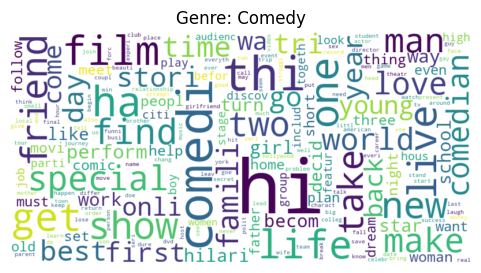

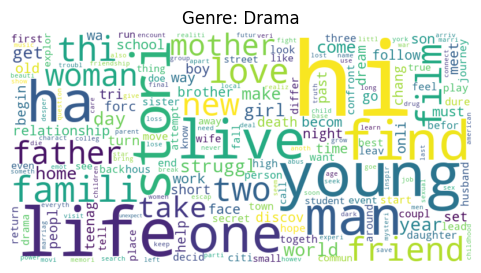

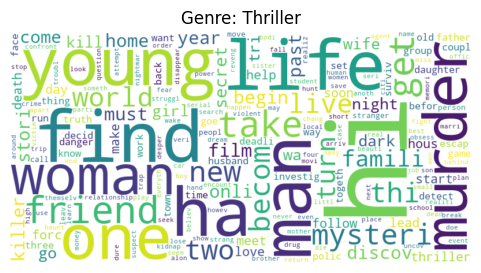

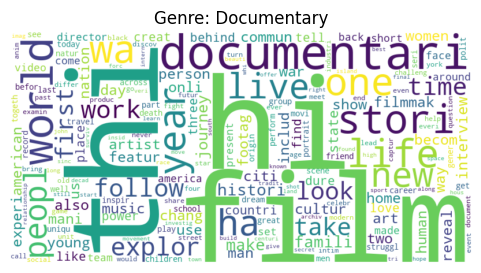

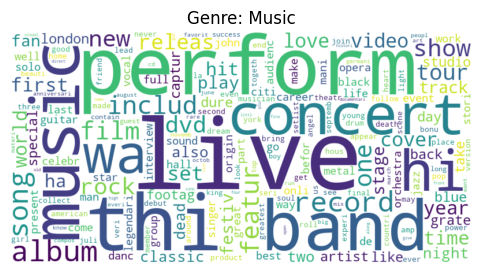

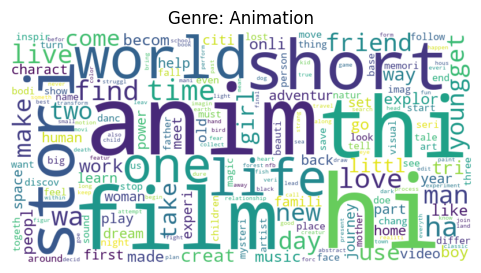

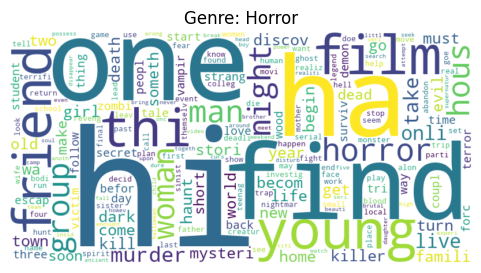

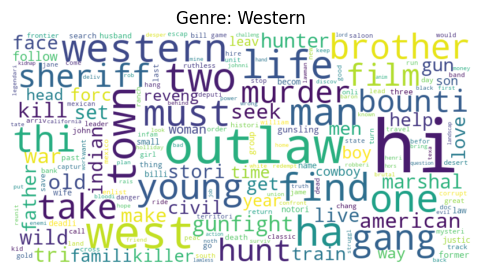

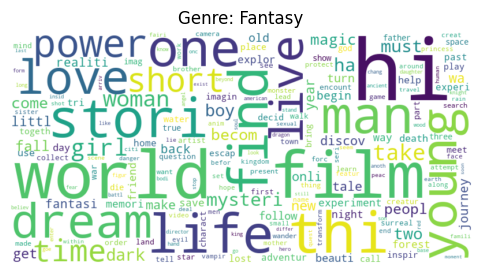

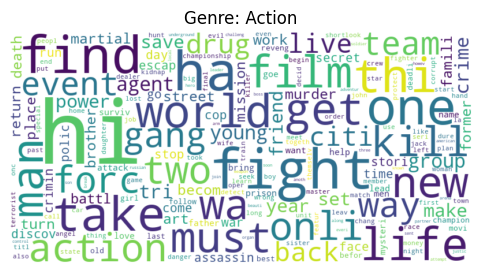

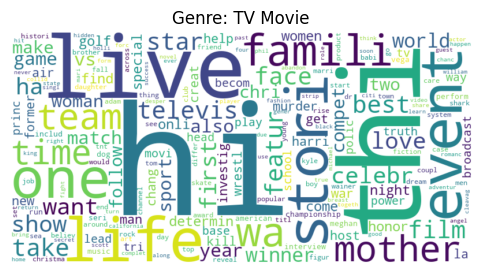

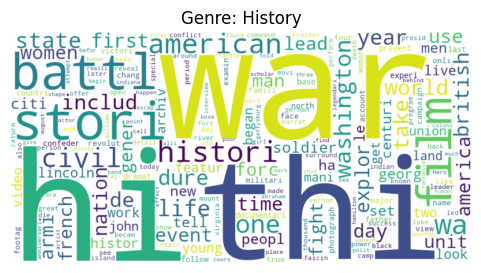

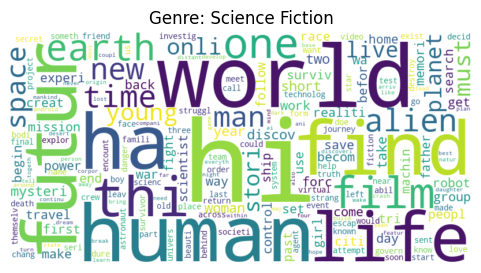

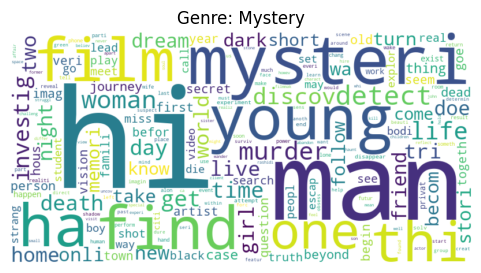

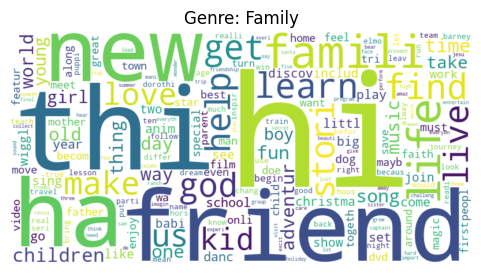

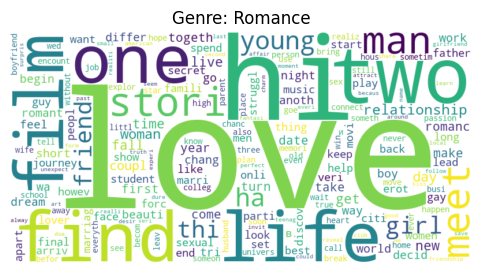

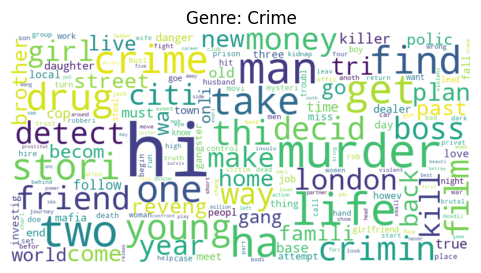

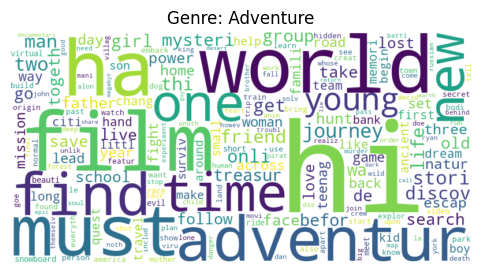

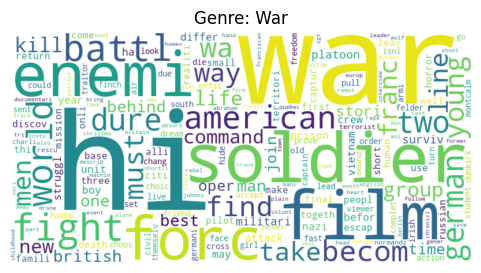

In [14]:
for genre, overview in combined_overviews.items():
    word_cloud = create_word_cloud(tokenize_text(overview))
    plot_word_cloud(word_cloud, genre)